In [1]:
import pymc3 as pm
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
import arviz as az

In [2]:
def addDateIndex(df, maxDate = None, minDate = None, fill_value = 0):
    #minDate = SP_Day['delivered'].min()
    if(maxDate == None):
        maxDate = df['date'].max()
        
    if(minDate == None):
        minDate = df['date'].min()

    idx = pd.date_range(minDate, maxDate)


    df = df.set_index('date')
    df.index = pd.DatetimeIndex(df.index)
    df = df.reindex(idx, fill_value=fill_value)
    return df


# Forecasts based on average troughput

In [3]:

finishedItems = pd.read_csv("/Users/robertk/Documents/GitHub/evolveNotebooks/Skeyos/DeliveredItems.csv")
finishedItems.columns = ['date', 'finishedCount']
finishedItems = addDateIndex(finishedItems)
finishedItems = finishedItems['20190101':'20191101']
finishedItems['finished_cumsum'] = finishedItems['finishedCount'].cumsum()


finishedItems.loc[:, 'WEEKDAY'] = ((pd.DatetimeIndex(finishedItems.index).dayofweek) // 5 == 0).astype(float)
finishedItems.loc[finishedItems.index.isin(['2019-01-01', '2019-01-06', '2019-04-22', '2019-06-09', '2019-06-20', '2019-08-15',
               '2019-11-01', '2019-11-11', '2019-12-25', '2019-12-26']), 'WEEKDAY'] = 0

finishedItems = finishedItems.loc[finishedItems['WEEKDAY'] == 1,]


finishedItems.loc[:, 'day'] = 1
finishedItems.loc[:, 'day'] = finishedItems['day'].cumsum()
finishedItems.loc[:, 'work_day'] = finishedItems['WEEKDAY'].cumsum()
finishedItems['troughput'] = finishedItems['finished_cumsum'] / finishedItems['work_day']

finishedItems.tail(20)

,finishedCount,finished_cumsum,WEEKDAY,day,work_day,troughput
2019-10-04,7,207,1.0,195,195.0,1.061538
2019-10-07,0,207,1.0,196,196.0,1.056122
2019-10-08,0,207,1.0,197,197.0,1.050761
2019-10-09,0,207,1.0,198,198.0,1.045455
2019-10-10,3,210,1.0,199,199.0,1.055276
2019-10-11,1,211,1.0,200,200.0,1.055000
2019-10-14,0,211,1.0,201,201.0,1.049751
2019-10-15,3,214,1.0,202,202.0,1.059406
2019-10-16,3,217,1.0,203,203.0,1.068966
2019-10-17,1,218,1.0,204,204.0,1.068627


/miniconda3/envs/bayes-env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


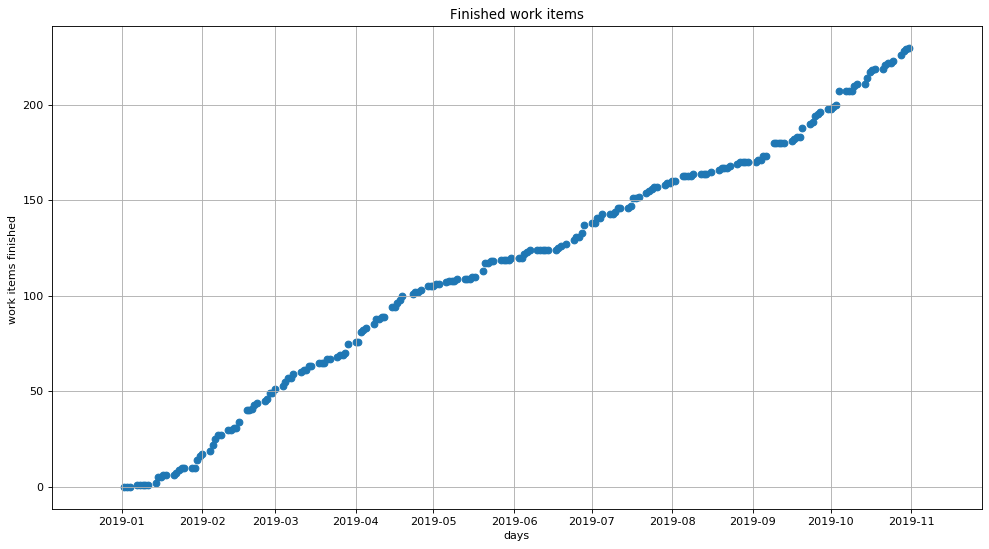

In [4]:
x_size = 15
y_size = 8
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')


plt.scatter(finishedItems.index, finishedItems['finished_cumsum'])
plt.grid()

plt.xlabel('days')
_ = plt.ylabel('work items finished ')
_ = plt.title('Finished work items')

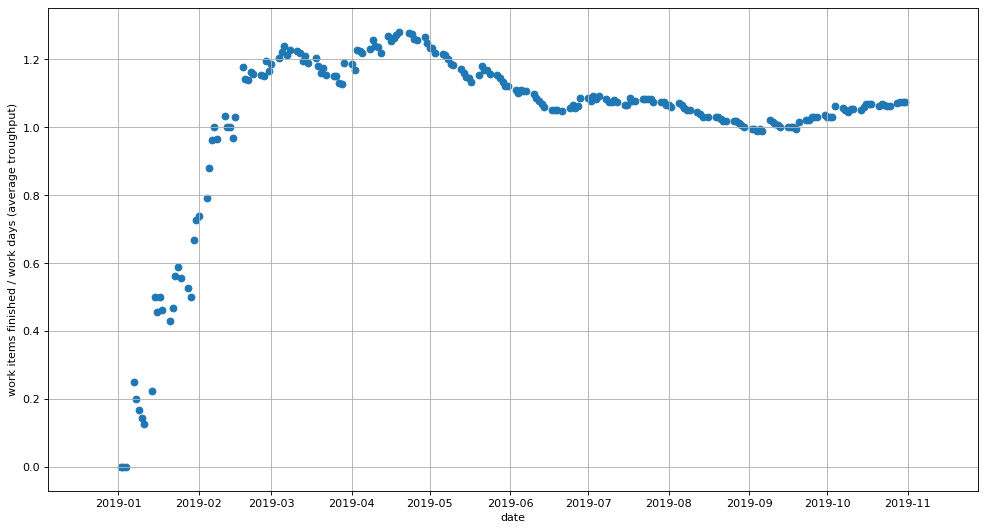

In [5]:
#plt.scatter(finishedItems.index, finishedItems['finished_cumsum'])
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(finishedItems.index, finishedItems['troughput'])
plt.grid()

plt.xlabel('date')
_ = plt.ylabel('work items finished / work days (average troughput)')


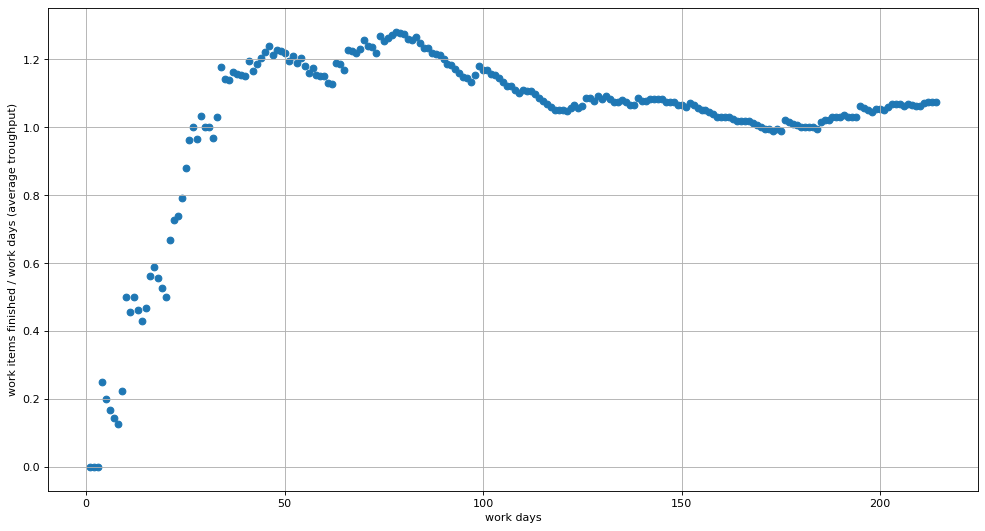

In [6]:
#plt.scatter(finishedItems.index, finishedItems['finished_cumsum'])
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(finishedItems.work_day, finishedItems['troughput'])
plt.grid()

plt.xlabel('work days')
_ = plt.ylabel('work items finished / work days (average troughput)')


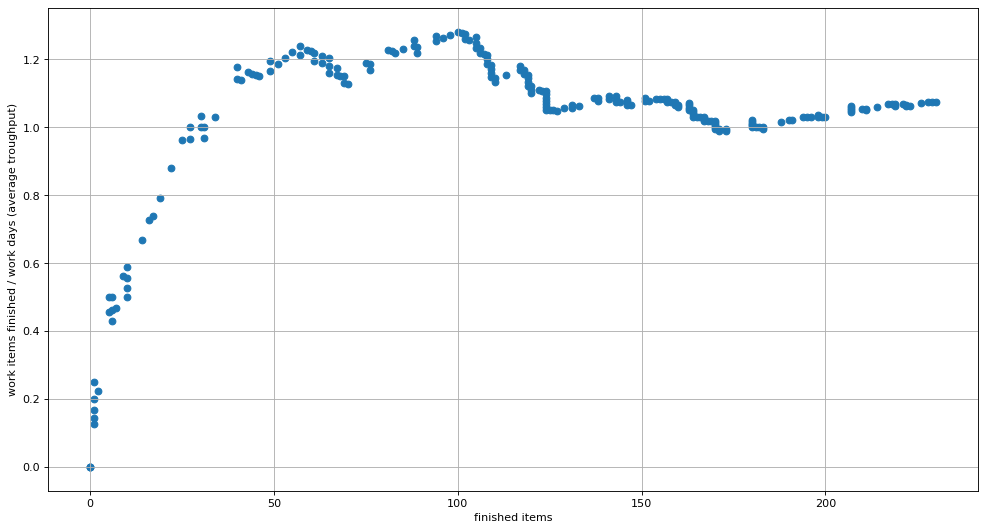

In [7]:
#plt.scatter(finishedItems.index, finishedItems['finished_cumsum'])
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(finishedItems.finished_cumsum, finishedItems['troughput'])
plt.grid()

plt.xlabel('finished items')
_ = plt.ylabel('work items finished / work days (average troughput)')



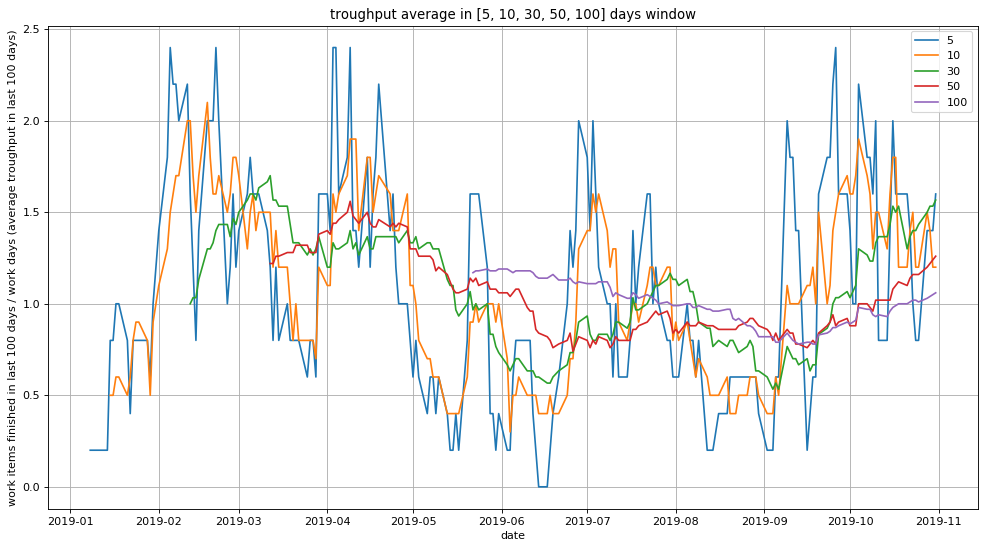

In [8]:
windowSizes = [5, 10, 30, 50, 100]
#windowSizes = [5]
finishedItemsRollSum = finishedItems.copy()
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
legend = []

for rollSize in windowSizes:
    legend.append(rollSize)
    

    finishedItemsRollSum['rollFinishedSum_{}'.format(rollSize)] =  finishedItemsRollSum['finishedCount'].rolling(rollSize, 
                                                                                                   min_periods=rollSize, 
                                                                                                   center=False).sum()

    finishedItemsRollSum['rollWEEKDAYSum_{}'.format(rollSize)] =  finishedItemsRollSum['WEEKDAY'].rolling(rollSize, 
                                                                                                   min_periods=rollSize, 
                                                                                                   center=False).sum()
    finishedItemsRollSum['roll_troughput_{}'.format(rollSize)] = finishedItemsRollSum['rollFinishedSum_{}'.format(rollSize)] / finishedItemsRollSum['rollWEEKDAYSum_{}'.format(rollSize)]


    
    plt.plot(finishedItemsRollSum.index, finishedItemsRollSum['roll_troughput_{}'.format(rollSize)])
    plt.grid()

    plt.xlabel('date')
    _ = plt.ylabel('work items finished in last {} days / work days (average troughput in last {} days)'.format(
        rollSize, rollSize))
    
    
    _= plt.title("troughput average in {} days window".format(legend))
    
    #_=plt.show()
    #finishedItemsRollSum['roll_troughput_{}'.format(5)].dropna().hist()
plt.legend(legend)
_=plt.show()

#finishedItemsRollSum.head(20)

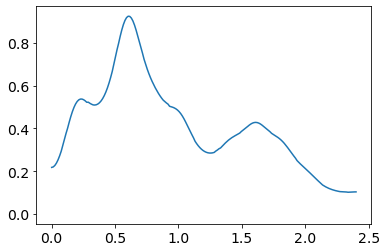

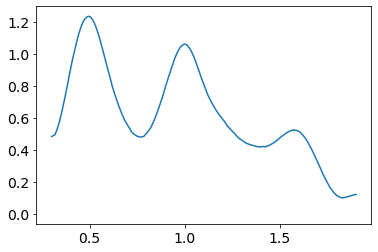

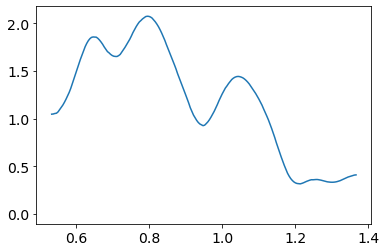

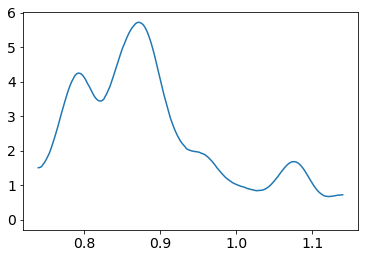

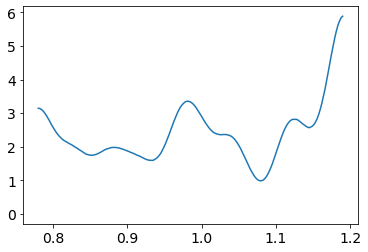

In [9]:
for rollSize in windowSizes:
    az.plot_kde(finishedItemsRollSum.iloc[100:200]['roll_troughput_{}'.format(rollSize)].dropna())
    plt.show()

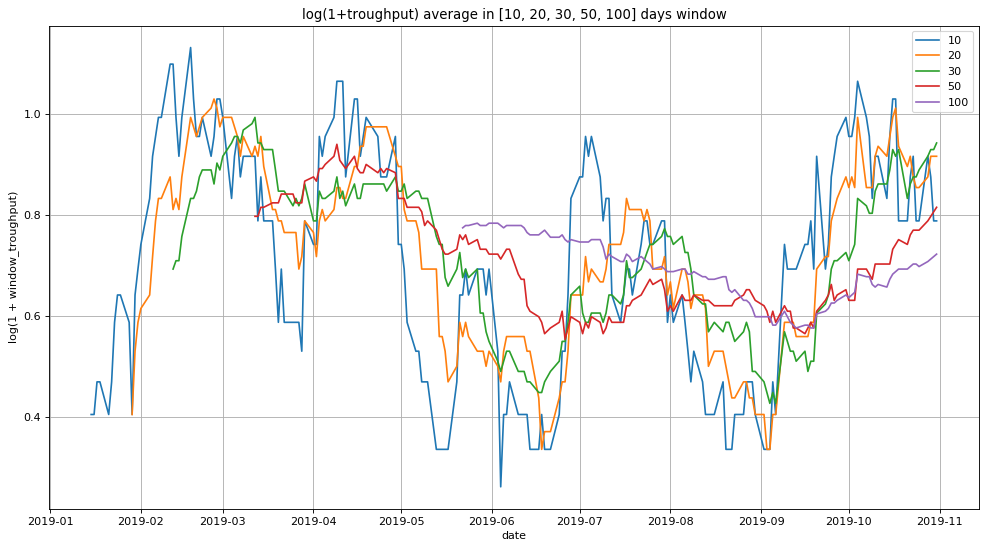

In [10]:
windowSizes = [10, 20, 30, 50, 100]
#windowSizes = [5]
finishedItemsRollSumLog = finishedItems.copy()
finishedItemsRollSumLog = finishedItemsRollSumLog.loc[finishedItemsRollSumLog.WEEKDAY == 1,]
#finishedItemsRollSum['finishedCount'] = np.log(finishedItemsRollSum['finishedCount'] + 1)
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
legend = []

for rollSize in windowSizes:
    legend.append(rollSize)
    

    finishedItemsRollSumLog['rollFinishedSum_{}'.format(rollSize)] =  finishedItemsRollSumLog['finishedCount'].rolling(rollSize, 
                                                                                                   min_periods=rollSize, 
                                                                                                   center=False).sum()

    finishedItemsRollSumLog['rollWEEKDAYSum_{}'.format(rollSize)] =  finishedItemsRollSumLog['WEEKDAY'].rolling(rollSize, 
                                                                                                   min_periods=rollSize, 
                                                                                                   center=False).sum()
    finishedItemsRollSumLog['roll_troughput_{}'.format(rollSize)] = np.log(1+finishedItemsRollSumLog['rollFinishedSum_{}'.format(rollSize)] / finishedItemsRollSumLog['rollWEEKDAYSum_{}'.format(rollSize)])


    
    plt.plot(finishedItemsRollSumLog.index, finishedItemsRollSumLog['roll_troughput_{}'.format(rollSize)])
    plt.grid()

    plt.xlabel('date')
    _ = plt.ylabel('log(1 + window_troughput)'.format(
        rollSize, rollSize))
    
    
    _= plt.title("log(1+troughput) average in {} days window".format(windowSizes))
    
    #_=plt.show()
    
plt.legend(legend)
_=plt.show()



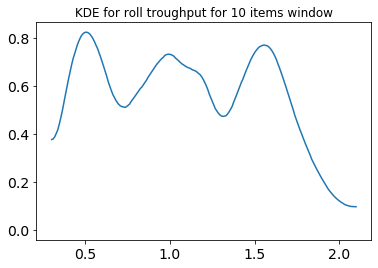

In [11]:
#finishedItemsRollSum['roll_troughput_{}'.format(10)].dropna().hist()
for rollSize in [10]:
    az.plot_kde(finishedItemsRollSum.iloc[0:]['roll_troughput_{}'.format(rollSize)].dropna())
    plt.title('KDE for roll troughput for {} items window'.format(rollSize))
    plt.show()


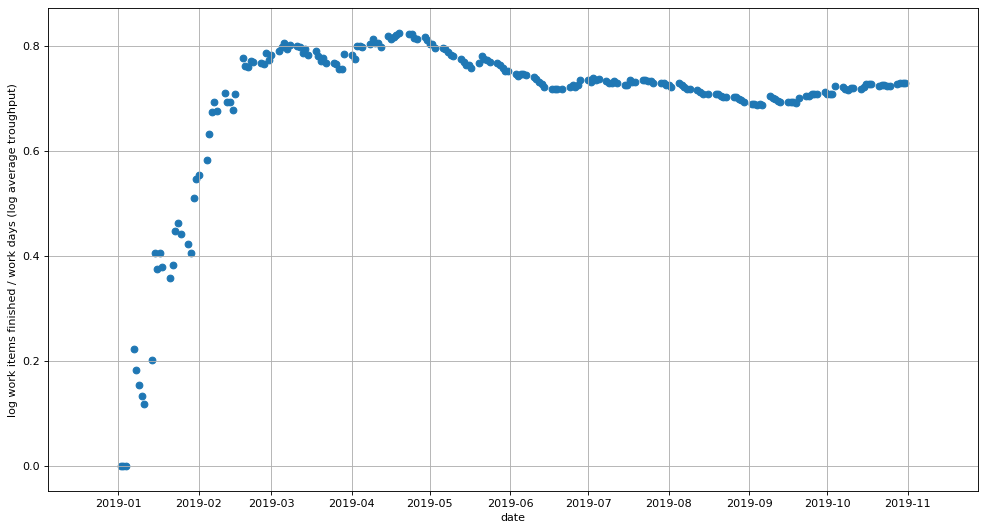

In [12]:
#plt.scatter(finishedItems.index, finishedItems['finished_cumsum'])
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(finishedItems.index, np.log(1+finishedItems['troughput']))
plt.grid()

plt.xlabel('date')
_ = plt.ylabel('log work items finished / work days (log average troughput)')


In [13]:
averageTroughputSamples = pd.DataFrame()

for finished in [10, 22, 51, 100, 151]:
#     print(finished)
#     print(finishedItems.loc[finishedItems['finished_cumsum'] == finished, ].iloc[0].T)
    averageTroughputSamples = pd.concat([averageTroughputSamples, 
                                         finishedItems.loc[finishedItems['finished_cumsum'] == finished, ].iloc[0:1]])

averageTroughputSamples

,finishedCount,finished_cumsum,WEEKDAY,day,work_day,troughput
2019-01-24,1,10,1.0,17,17.0,0.588235
2019-02-05,3,22,1.0,25,25.0,0.880000
2019-03-01,2,51,1.0,43,43.0,1.186047
2019-04-19,2,100,1.0,78,78.0,1.282051
2019-07-17,4,151,1.0,139,139.0,1.086331


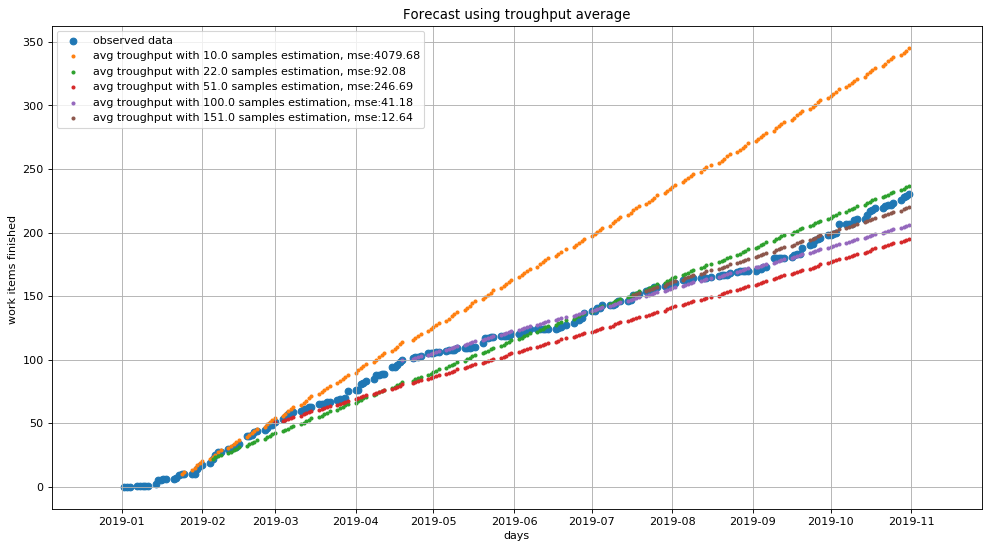

In [14]:
averageTroughputForecast = finishedItems.copy()

figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(averageTroughputForecast.index, averageTroughputForecast['finished_cumsum'])
plt.grid()
legend = ['observed data']
plt.xlabel('days')
_ = plt.ylabel('work items finished ')
_= plt.title("Forecast using troughput average")
for index, row in averageTroughputSamples.iterrows():
    #print(index, row)
    sample_size = row['finished_cumsum']
    columnName = "estWith{}finishedItems".format(sample_size)
    
    #for mse calculations. mse on samples before sample_size should be 0 so value is the same as observed
    averageTroughputForecast[columnName] = averageTroughputForecast['finished_cumsum']
    averageTroughputForecast.loc[averageTroughputForecast.index >= index, 
                                 columnName] = row['finished_cumsum'] + ((averageTroughputForecast['work_day'] - row['work_day']) / row['troughput'])
    
    mse = mean_squared_error(averageTroughputForecast['finished_cumsum'], averageTroughputForecast[columnName]).round(2)
    legend.append("avg troughput with {} samples estimation, mse:{}".format(sample_size, mse))

    #remove observed value before sample_size observations
    averageTroughputForecast.loc[averageTroughputForecast.index < index, 
                                 columnName] = None

    plt.scatter(finishedItems.index, averageTroughputForecast[columnName], s=7)

    
    
plt.legend(legend)


In [15]:
work_days_max = finishedItems.work_day.max()

In [16]:
averageTroughputSamples

,finishedCount,finished_cumsum,WEEKDAY,day,work_day,troughput
2019-01-24,1,10,1.0,17,17.0,0.588235
2019-02-05,3,22,1.0,25,25.0,0.880000
2019-03-01,2,51,1.0,43,43.0,1.186047
2019-04-19,2,100,1.0,78,78.0,1.282051
2019-07-17,4,151,1.0,139,139.0,1.086331


Calculations after 10.0 finished items


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [troughput_sim, sigma_troughput, mu_troughput]
Sampling 4 chains, 276 divergences: 100%|██████████| 44000/44000 [00:14<00:00, 2988.34draws/s]
The acceptance probability does not match the target. It is 0.8789936825992214, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 275 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5568084096636883, but should be close to 0.8. Try to increase the number of tuning steps.


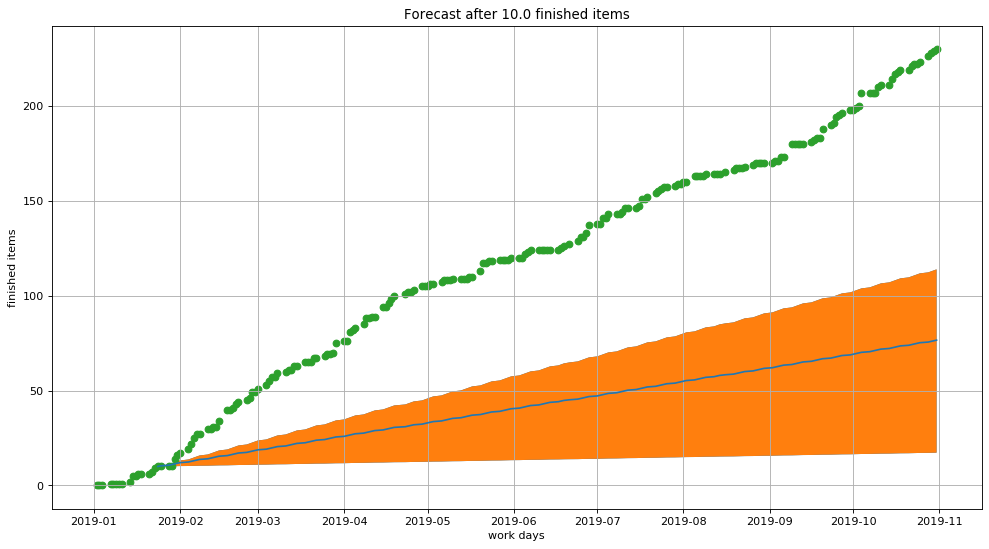

Calculations after 22.0 finished items


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [troughput_sim, sigma_troughput, mu_troughput]
Sampling 4 chains, 1 divergences: 100%|██████████| 44000/44000 [00:14<00:00, 2999.86draws/s]
The acceptance probability does not match the target. It is 0.9013829103590583, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9069694286170468, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


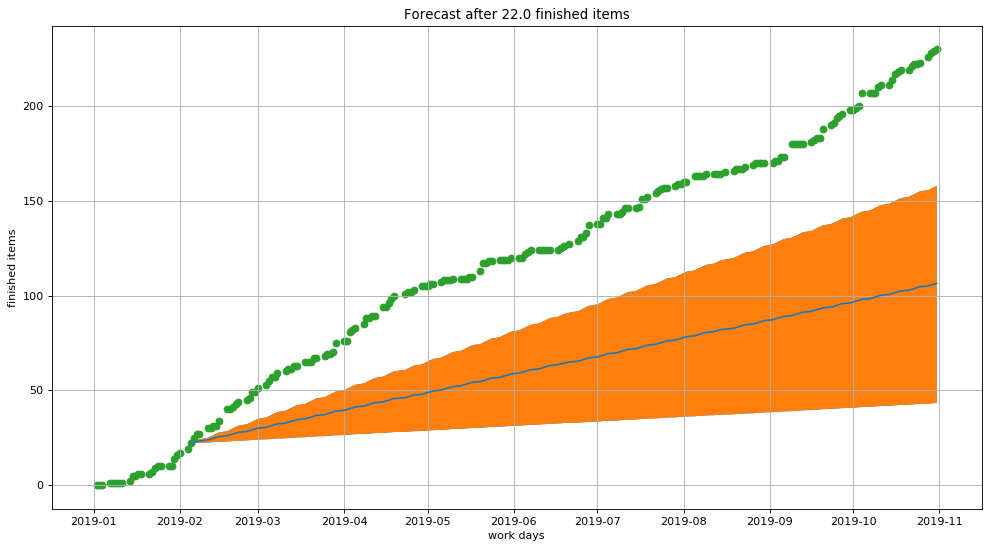

Calculations after 51.0 finished items


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [troughput_sim, sigma_troughput, mu_troughput]
Sampling 4 chains, 3 divergences: 100%|██████████| 44000/44000 [00:13<00:00, 3227.90draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


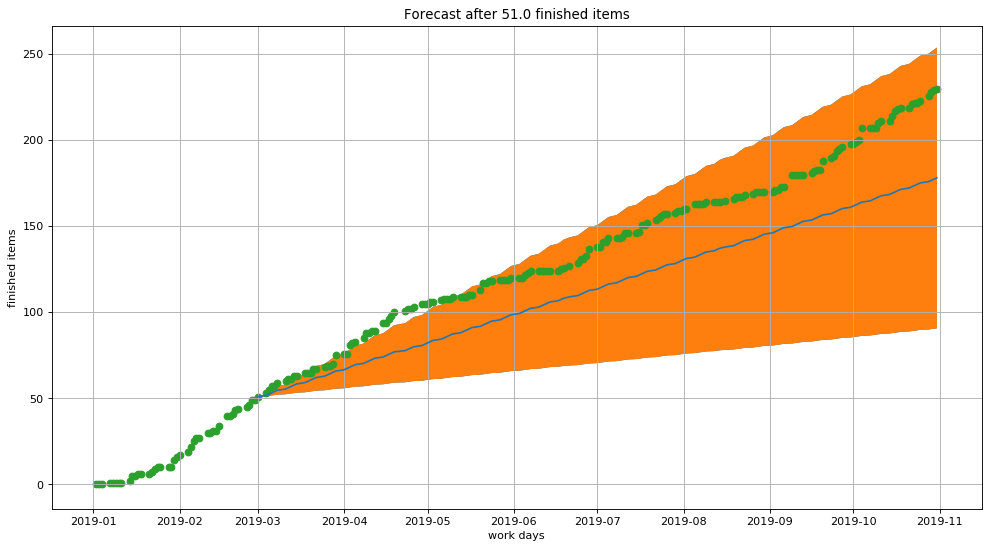

Calculations after 100.0 finished items


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [troughput_sim, sigma_troughput, mu_troughput]
Sampling 4 chains, 3 divergences: 100%|██████████| 44000/44000 [00:13<00:00, 3243.05draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8930165157871013, but should be close to 0.8. Try to increase the number of tuning steps.


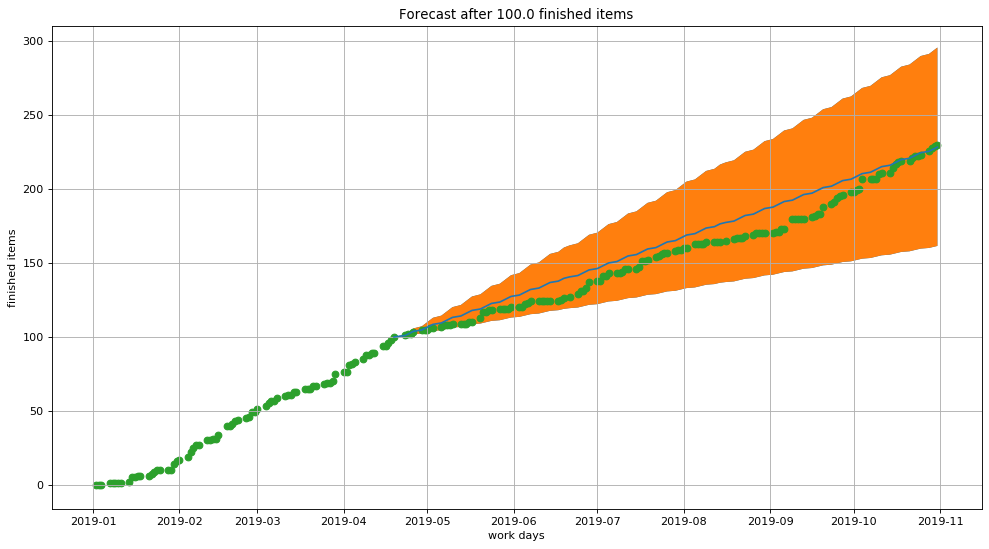

Calculations after 151.0 finished items


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [troughput_sim, sigma_troughput, mu_troughput]
Sampling 4 chains, 59 divergences: 100%|██████████| 44000/44000 [00:13<00:00, 3204.93draws/s]
The acceptance probability does not match the target. It is 0.9087900005311454, but should be close to 0.8. Try to increase the number of tuning steps.
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.49759220907859353, but should be close to 0.8. Try to increase the number of tuning steps.


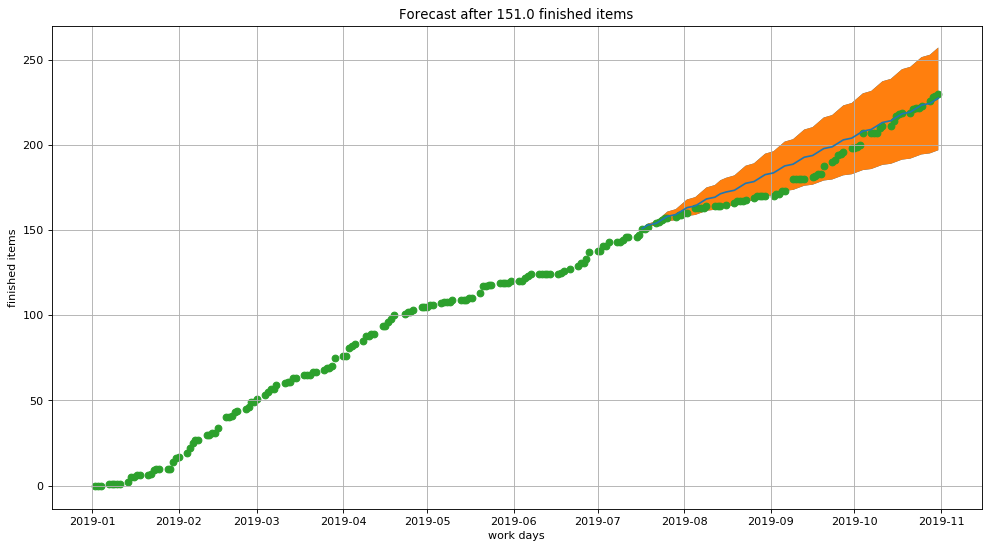

In [17]:

for index, row in averageTroughputSamples.iterrows():
    
    finished_cumsum = row['finished_cumsum']
    print('Calculations after {} finished items'.format( finished_cumsum))
    samples = averageTroughputForecast.loc[averageTroughputForecast.index < index, 
                                                                        'troughput']
    
    with pm.Model() as no_observation_model_only_troughput:
        
        BoundNormal = pm.Bound(pm.Normal, lower=0.0, upper=1000)
        mu_troughput = BoundNormal("mu_troughput", 1, .4)
        sigma_troughput = pm.Exponential('sigma_troughput', lam=0.01)

        troughput_obs = pm.Normal("troughput_obs", mu_troughput, sigma_troughput, observed=samples)
        troughput_sim = BoundNormal("troughput_sim", mu_troughput, sigma_troughput)
        
        
        trace = pm.sample(10000, tune=1000) 
        

    work_days = finishedItems.loc[finishedItems.index >= index, 'work_day']

    figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')

    #plt.plot(work_days, est_finishedItems.mean(1), 'C0')
    #plt.plot(items_avg, mu_calc, 'C1', color='green')
    plt.grid()
    #az.plot_hpd(work_days, est_finishedItems.T, credible_interval=.90)

    troughputHDP = az.hpd(trace['troughput_sim'], credible_interval=0.8)
    est_finishedItems_low = row['finished_cumsum'] +  (work_days - row['work_day']) * troughputHDP[0]
    est_finishedItems_high = row['finished_cumsum'] +  (work_days - row['work_day']) * troughputHDP[1]
    est_finishedItems_mean = row['finished_cumsum'] +  (work_days - row['work_day']) * trace['troughput_sim'].mean()


    plt.fill_between(finishedItems.index[len(finishedItems)-len(est_finishedItems_high):], 
                 est_finishedItems_low, est_finishedItems_high)


    plt.fill_between(finishedItems.index[len(finishedItems)-len(est_finishedItems_high):], 
                     est_finishedItems_low, est_finishedItems_high)
    plt.scatter(finishedItems.index, finishedItems['finished_cumsum'])
    plt.plot(finishedItems.index[len(finishedItems)-len(est_finishedItems_high):], est_finishedItems_mean)

    plt.xlabel('work days')
    plt.ylabel('finished items')
    plt.title('Forecast after {} finished items'.format( row['finished_cumsum']));
    plt.show()

    


In [18]:
#averageTroughputForecast.head()

Calculations after 10.0 finished items


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_finished, troughput]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [00:10<00:00, 4342.47draws/s]
/miniconda3/envs/bayes-env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 813.54it/s]


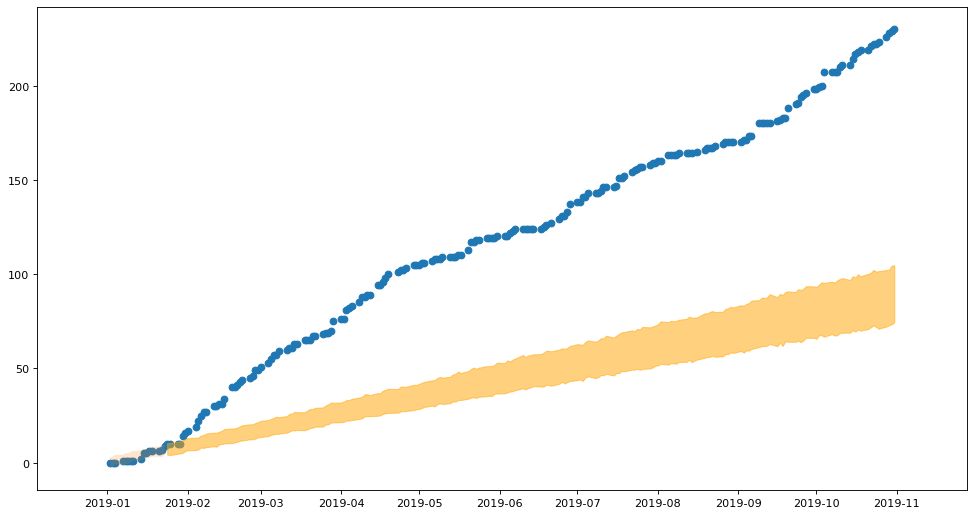

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Calculations after 22.0 finished items


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_finished, troughput]
Sampling 4 chains, 0 divergences: 100%|██████████| 44000/44000 [00:09<00:00, 4517.58draws/s]
/miniconda3/envs/bayes-env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 779.65it/s]


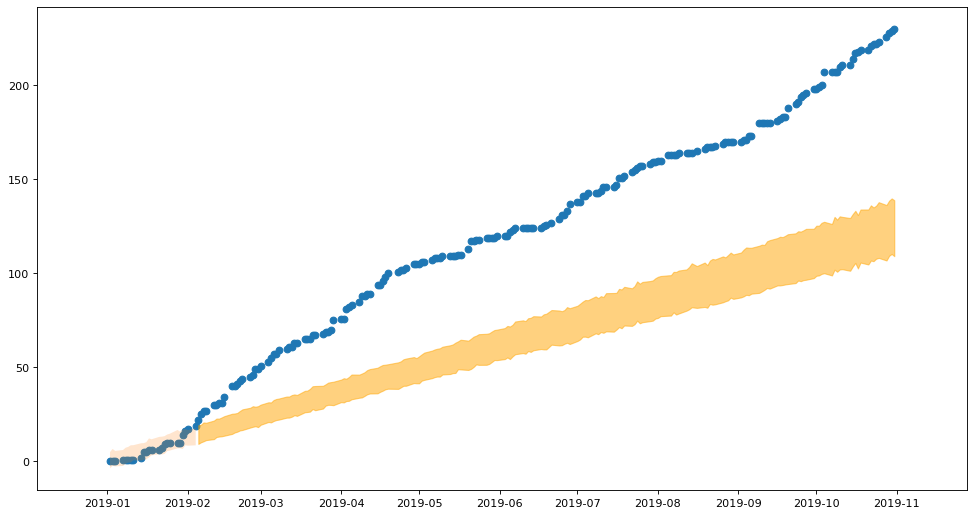

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Calculations after 51.0 finished items


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_finished, troughput]
Sampling 4 chains, 184 divergences: 100%|██████████| 44000/44000 [00:10<00:00, 4219.93draws/s]
There were 142 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6958332447544341, but should be close to 0.8. Try to increase the number of tuning steps.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
/miniconda3/envs/bayes-env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:

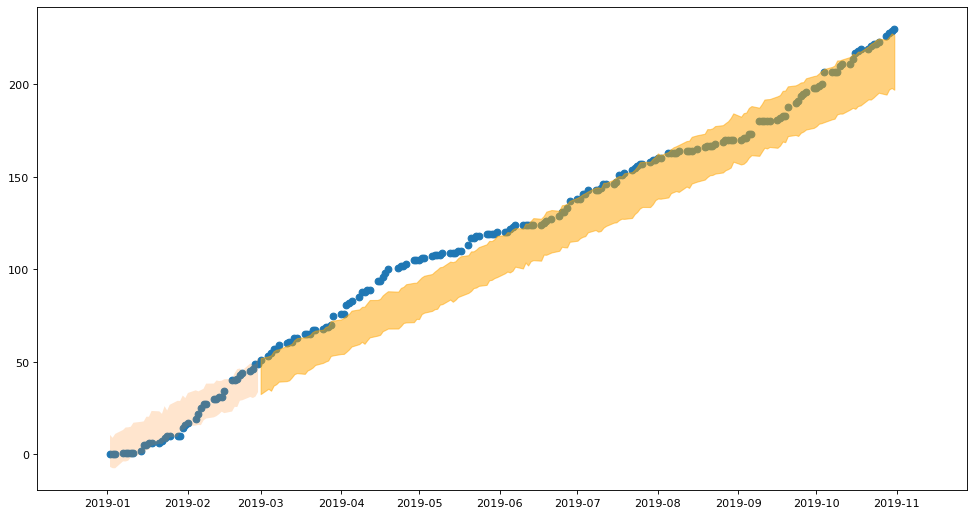

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Calculations after 100.0 finished items


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_finished, troughput]
Sampling 4 chains, 52 divergences: 100%|██████████| 44000/44000 [00:11<00:00, 3972.31draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
/miniconda3/envs/bayes-env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 858.22it/s]


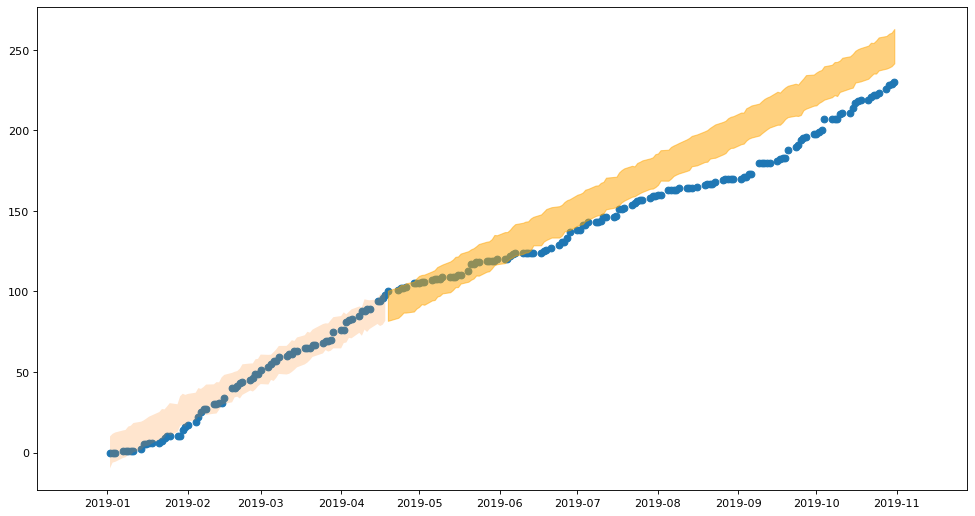

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Calculations after 151.0 finished items


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_finished, troughput]
Sampling 4 chains, 11 divergences: 100%|██████████| 44000/44000 [00:10<00:00, 4385.85draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
/miniconda3/envs/bayes-env/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 200/200 [00:00<00:00, 834.95it/s]


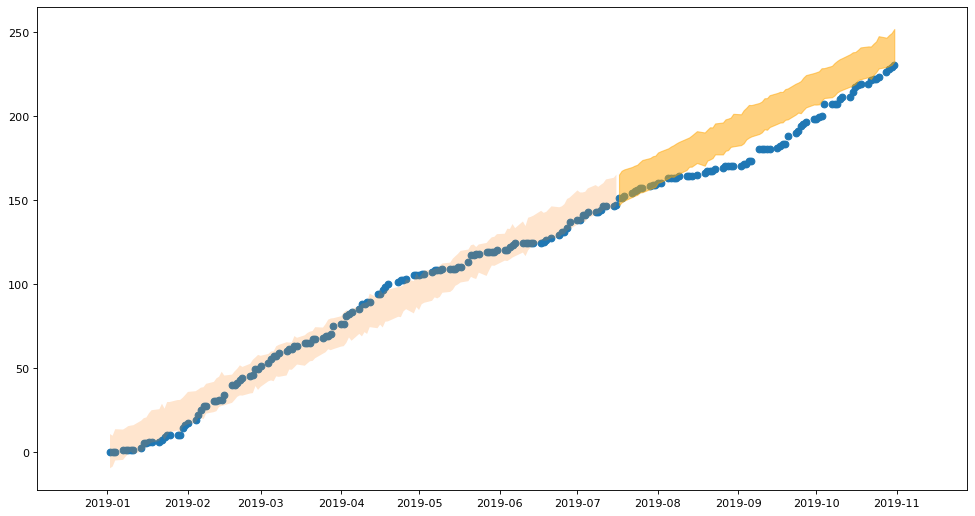

In [40]:

for index, row in averageTroughputSamples.iterrows():
    
    finished_cumsum = row['finished_cumsum']
    print('Calculations after {} finished items'.format( finished_cumsum))
    samples = averageTroughputForecast.loc[averageTroughputForecast.index < index, ]
    #print(samples.head())
    
    with pm.Model() as troughput_model:
        
        BoundNormal = pm.Bound(pm.Normal, lower=0.0, upper=1000)
        troughput = pm.Normal("troughput", 2,2)
        sigma_finished = pm.Uniform('sigma_finished', lower=0, upper=5)
        mu_finished = pm.Deterministic("mu_finished", 1 / troughput * samples.work_day)

        finished_obs = pm.Normal("finished_obs", mu_finished, sigma_finished, observed=samples.finished_cumsum)
        
        trace_troughput_model = pm.sample(10000, tune=1000) 
        

    afterIndex = averageTroughputForecast.loc[finishedItems.index >= index, ]

    figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(averageTroughputForecast.index, averageTroughputForecast['finished_cumsum'])


    finished_pred_samples = pm.sample_posterior_predictive(trace_troughput_model, 200, troughput_model)
    finished_pred_hpd = az.hpd(finished_pred_samples['finished_obs'])
    #az.plot_hpd(samples.work_day, finished_pred_samples['finished_obs'])

    plt.fill_between(samples.index, finished_pred_hpd[:,0], finished_pred_hpd[:,1], alpha=.2)

    post_samples = []

    for _ in range(1000): # number of samples from the posterior
        i = np.random.randint(len(trace_troughput_model))
        mu_finished =  1 / trace_troughput_model['troughput'][i] * afterIndex.work_day
        sigma_pred = trace_troughput_model['sigma_finished'][i]
        post_samples.append(np.random.normal(mu_finished, sigma_pred))

    predicted_hpd = az.hpd(np.array(post_samples))
    plt.fill_between(afterIndex.index, predicted_hpd[:,0], predicted_hpd[:,1], alpha=.5, color='orange')
    plt.show()
    


In [38]:
#_ = pm.traceplot(trace_troughput_model)

In [66]:
# print(len(trace['troughput_sim']))
# thin_trace = trace[::400]
# print(len(thin_trace))
# print(thin_trace.nchains)

# figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
# plt.grid()
# #weight_seq = np.arange(25, 100)
# # Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# #chain_N_thinned = chain_N[::10]
# finished_pred = np.zeros((len(finishedItems.work_day), len(thin_trace)*thin_trace.nchains))
# print(finished_pred.shape)
# for i, w in enumerate(finishedItems.work_day):
#     finished_pred[i] =  finishedItems.work_day[i] * thin_trace['troughput_sim']
    
# _=plt.plot(finishedItems.work_day, finished_pred, 'C0.', alpha=0.1)
# _=plt.plot(finishedItems.work_day, finished_pred.mean(1), 'C1.', alpha=0.1)

In [42]:
# troughputHPD = az.hpd(trace['troughput_sim'], credible_interval=0.8)
# print(troughputHPD)
# az.plot_kde(trace['troughput_sim'], quantiles= [.05, .95])
# plt.xlabel('finished items')
# plt.xticks([151, 160, 170, 180, 190, 200, 210, 220, 230]);


In [39]:
#_ = pm.traceplot(trace)

# Little's Law calculations

In [41]:
wipObservations = pd.read_csv("/Users/robertk/Documents/GitHub/evolveNotebooks/Skeyos/InProgressObservations.csv")
wipObservations.head()

wipObservations = addDateIndex(wipObservations)
wipObservations.columns = ['wip']

wipObservations.head()

,wip
2018-11-01,9
2018-11-02,10
2018-11-03,10
2018-11-04,10
2018-11-05,11


In [42]:
wipObservations.iloc[:10]

,wip
2018-11-01,9
2018-11-02,10
2018-11-03,10
2018-11-04,10
2018-11-05,11
2018-11-06,12
2018-11-07,11
2018-11-08,9
2018-11-09,10
2018-11-10,8


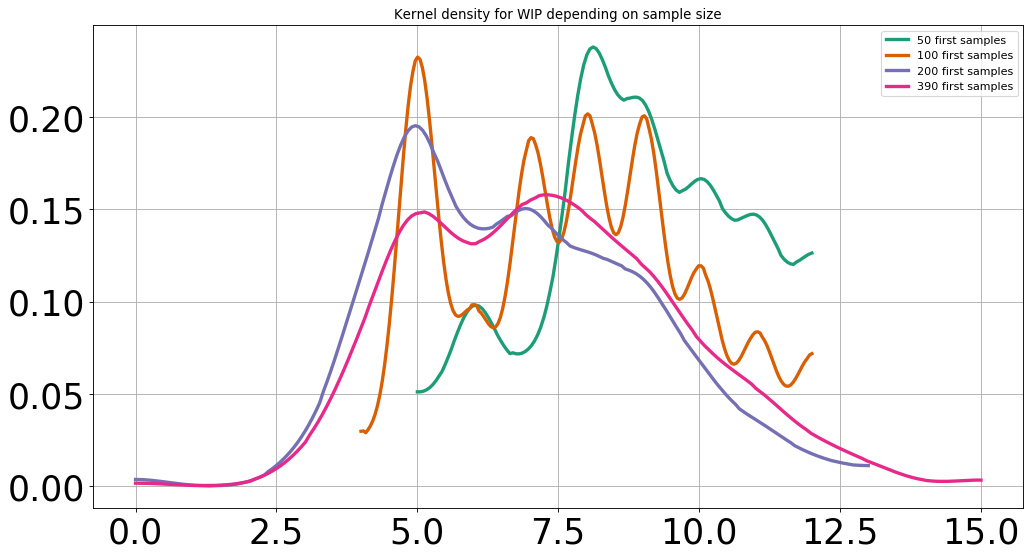

In [43]:
from matplotlib.pyplot import cm
colors=cm.Dark2.colors

finishedItemsCount = [50, 100, 200, len(wipObservations)]
#colors = ['red', 'green', 'orange', 'black']
color = 0;

figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
for i in finishedItemsCount:
    az.plot_kde(wipObservations.iloc[:i], 
                label="{} first samples".format(i), 
                plot_kwargs={"linewidth": 3, "color": colors[color]})
    color+=1
plt.grid()
_ = plt.title('Kernel density for WIP depending on sample size')

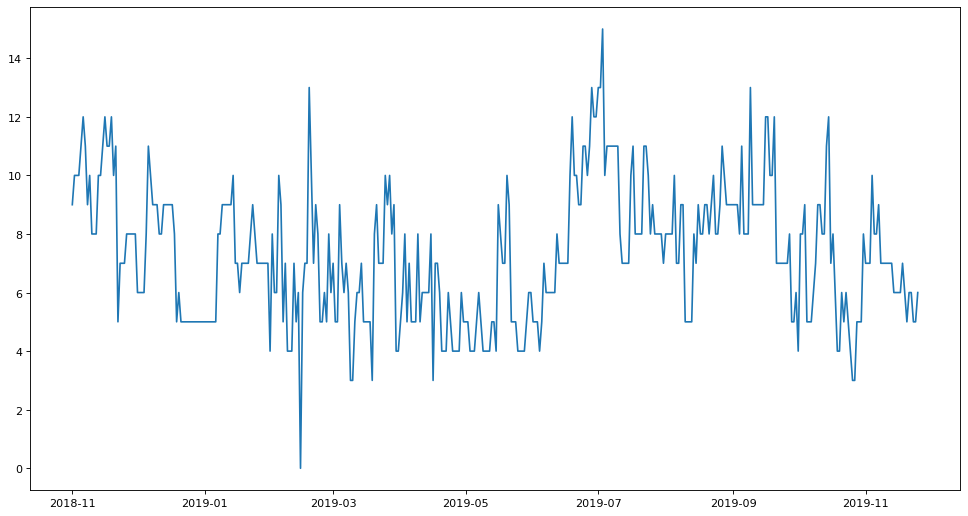

In [68]:
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
plt.plot(wipObservations.index, wipObservations.wip)

In [44]:

minDate = finishedItems.index.min()
maxDate = finishedItems.index.max()
print(minDate, maxDate)
#finishedItems.head()

2019-01-02 00:00:00 2019-10-31 00:00:00


In [45]:
cycleObservations = pd.read_csv("/Users/robertk/Documents/GitHub/evolveNotebooks/Skeyos/DaysInDev.csv")

cycleObservations = cycleObservations[['finish date', 'days in dev', 'key']]
cycleObservations.columns = ['date', 'cycleTime', 'key']
cycleObservations = cycleObservations.sort_values(by=['date'])
#print (cycleObservations[cycleObservations.duplicated(subset=['date'],keep=False)])
cycleObservations['date'] = pd.to_datetime(cycleObservations['date'])
#cycleObservations.head()




#cycleObservations = addDateIndex(cycleObservations)



cycleObservations = cycleObservations.groupby('date').agg({'cycleTime': ['mean']})
cycleObservations.columns = [' '.join(col).strip() for col in cycleObservations.columns.values]
cycleObservations.reset_index(inplace=True)





cycleObservations = addDateIndex(cycleObservations, maxDate = maxDate, minDate=minDate, fill_value=0)
cycleObservations.columns = ['cycleTime']
#cycleObservations.head()
cycleTime_WIP = pd.merge(cycleObservations, wipObservations, left_index=True, right_index=True, how='left')
cycleTime_WIP.head()

,cycleTime,wip
2019-01-02,0.0,5
2019-01-03,0.0,5
2019-01-04,0.0,5
2019-01-05,0.0,5
2019-01-06,0.0,5


In [52]:
finishedItems.head()

,finishedCount,finished_cumsum,WEEKDAY,day,work_day,troughput
2019-01-02,0,0,1.0,1,1.0,0.00
2019-01-03,0,0,1.0,2,2.0,0.00
2019-01-04,0,0,1.0,3,3.0,0.00
2019-01-07,1,1,1.0,4,4.0,0.25
2019-01-08,0,1,1.0,5,5.0,0.20


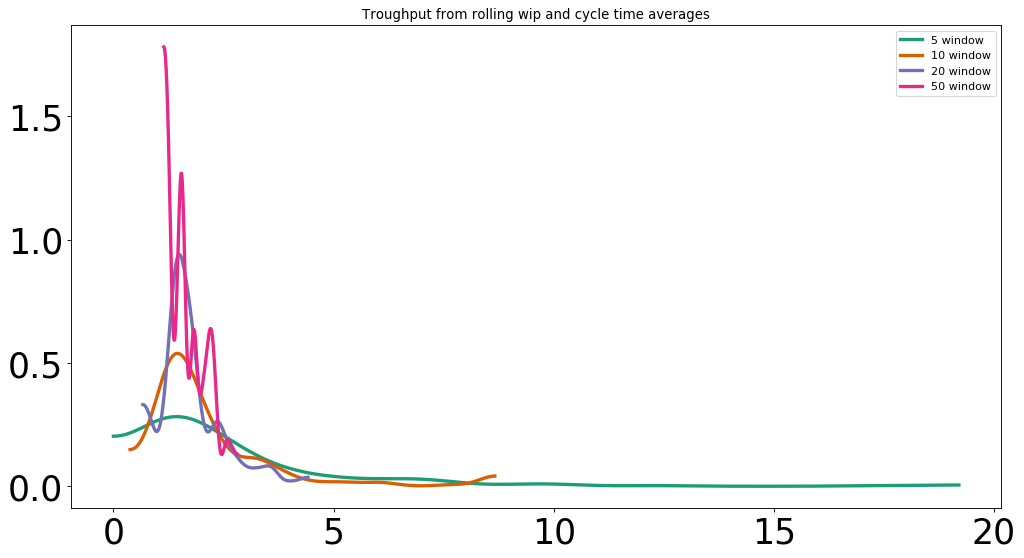

In [55]:
windowSizes = [5, 10, 20, 50]
#windowSizes = [5]
cycleTime_WIP_rollAvg = cycleTime_WIP.copy()

cycleTime_WIP_rollAvg = pd.merge(cycleTime_WIP_rollAvg, finishedItems['finishedCount'], 
                                left_index=True, right_index=True)


#not include 0 in mean calculation
#cycleTime_WIP_rollAvg.loc[cycleTime_WIP_rollAvg.cycleTime == 0, 'cycleTime'] = np.NAN
cycleTime_WIP_rollAvg['cycleTimeExist'] = 0
cycleTime_WIP_rollAvg.loc[cycleTime_WIP_rollAvg['cycleTime'] != 0, 'cycleTimeExist'] = 1







legend = []
#figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')

from matplotlib.pyplot import cm
colors=cm.Dark2.colors
color = 0
figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
for rollSize in windowSizes:
    legend.append(rollSize)
    

    cycleTime_WIP_rollAvg['cycleTimeSum_{}'.format(rollSize)] =  cycleTime_WIP_rollAvg['cycleTime'].rolling(
        rollSize, min_periods=rollSize, center=False).sum()
    
    cycleTime_WIP_rollAvg['cycleTimeCount_{}'.format(rollSize)] =  cycleTime_WIP_rollAvg['cycleTimeExist'].rolling(
        rollSize, min_periods=rollSize, center=False).sum()
    
    cycleTime_WIP_rollAvg['cycleTimeAvg_{}'.format(rollSize)] = cycleTime_WIP_rollAvg['cycleTimeSum_{}'.format(rollSize)] / cycleTime_WIP_rollAvg['cycleTimeCount_{}'.format(rollSize)]
    
    cycleTime_WIP_rollAvg['wipAvg_{}'.format(rollSize)] =  cycleTime_WIP_rollAvg['wip'].rolling(
        rollSize, min_periods=rollSize, center=False).mean()
    
    cycleTime_WIP_rollAvg['finishedSum_{}'.format(rollSize)] =  cycleTime_WIP_rollAvg['finishedCount'].rolling(
        rollSize, min_periods=rollSize, center=False).sum()
    
    cycleTime_WIP_rollAvg['troughput_{}'.format(rollSize)] =  (cycleTime_WIP_rollAvg['wipAvg_{}'.format(rollSize)] / cycleTime_WIP_rollAvg['cycleTimeAvg_{}'.format(rollSize)])
    
    az.plot_kde(cycleTime_WIP_rollAvg['troughput_{}'.format(rollSize)], 
                label="{} window".format(rollSize), 
                plot_kwargs={"linewidth": 3, "color": colors[color]})
    color+=1
    

_=plt.title('Troughput from rolling wip and cycle time averages')

In [62]:
cycleTime_WIP_rollAvg.filter(regex=".*_5$|cycleTime$").head(20)

,cycleTime,cycleTimeSum_5,cycleTimeCount_5,cycleTimeAvg_5,wipAvg_5,finishedSum_5,troughput_5
2019-01-02,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,0.000000,0.000000e+00,0.0,NaN,6.2,1.0,NaN
2019-01-09,0.000000,0.000000e+00,0.0,NaN,7.0,1.0,NaN
2019-01-10,0.000000,0.000000e+00,0.0,NaN,7.8,1.0,NaN
2019-01-11,0.000000,0.000000e+00,0.0,NaN,8.6,1.0,NaN
2019-01-14,6.000000,6.000000e+00,1.0,6.000000,9.0,1.0,1.500000
2019-01-15,3.333333,9.333333e+00,2.0,4.666667,8.8,4.0,1.885714


In [72]:
windowSizes = [5]
sampleSize = 5

for windowSize in windowSizes:
    
    finished_cumsum = row['finished_cumsum']
    print('Calculations for {} size window, sample size {}'.format(windowSize, sample_size))
    samples = cycleTime_WIP_rollAvg[:sampleSize]
    #print(len(samples))
    
    with pm.Model() as littles_law_model:
        
        BoundNormal = pm.Bound(pm.Normal, lower=0.0, upper=1000)
        troughput = pm.Deterministic("troughput", 
                                     samples['wipAvg_{}'.format(rollSize)] / samples['cycleTimeAvg_{}'.format(rollSize)])
#         troughput = pm.Normal("troughput", 2,2)
#         sigma_finished = pm.Uniform('sigma_finished', lower=0, upper=5)
#         mu_finished = pm.Deterministic("mu_finished", 1 / troughput * samples.work_day)

#         finished_obs = pm.Normal("finished_obs", mu_finished, sigma_finished, observed=samples.finished_cumsum)
        
#         trace_troughput_model = pm.sample(10000, tune=1000) 
        

#     afterIndex = averageTroughputForecast.loc[finishedItems.index >= index, ]

#     figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
#     plt.scatter(averageTroughputForecast.index, averageTroughputForecast['finished_cumsum'])


#     finished_pred_samples = pm.sample_posterior_predictive(trace_troughput_model, 200, troughput_model)
#     finished_pred_hpd = az.hpd(finished_pred_samples['finished_obs'])
#     #az.plot_hpd(samples.work_day, finished_pred_samples['finished_obs'])

#     plt.fill_between(samples.index, finished_pred_hpd[:,0], finished_pred_hpd[:,1], alpha=.2)

#     post_samples = []

#     for _ in range(1000): # number of samples from the posterior
#         i = np.random.randint(len(trace_troughput_model))
#         mu_finished =  1 / trace_troughput_model['troughput'][i] * afterIndex.work_day
#         sigma_pred = trace_troughput_model['sigma_finished'][i]
#         post_samples.append(np.random.normal(mu_finished, sigma_pred))

#     predicted_hpd = az.hpd(np.array(post_samples))
#     plt.fill_between(afterIndex.index, predicted_hpd[:,0], predicted_hpd[:,1], alpha=.5, color='orange')
#     plt.show()
    


Calculations for 5 size window, sample size 151.0
5


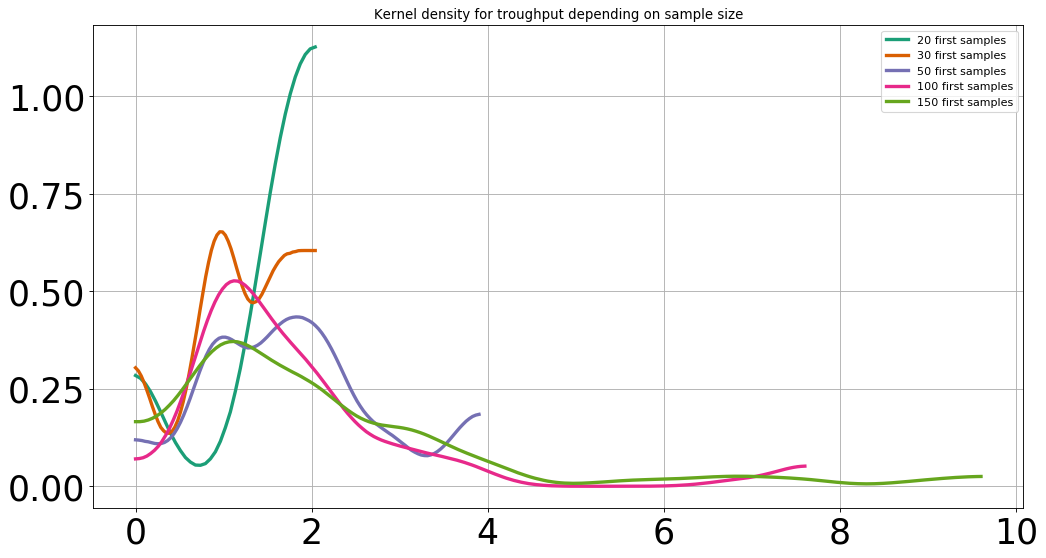

In [48]:
from matplotlib.pyplot import cm
colors=cm.Dark2.colors

color = 0;

figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
windowSize = 5
for i in [20,30,50,100, 150]:
    az.plot_kde(cycleTime_WIP_rollAvg['troughput_{}'.format(windowSize)][:i], 
                label="{} first samples".format(i), 
                plot_kwargs={"linewidth": 3, "color": colors[color]})
    color+=1

plt.grid()
_ = plt.title('Kernel density for troughput depending on sample size')

In [49]:

cycleObservations.loc[:, 'WEEKDAY'] = ((pd.DatetimeIndex(cycleObservations.index).dayofweek) // 5 == 0).astype(float)
cycleObservations.loc[cycleObservations.index.isin(['2019-01-01', '2019-01-06', '2019-04-22', '2019-06-09', '2019-06-20', '2019-08-15',
               '2019-11-01', '2019-11-11', '2019-12-25', '2019-12-26']), 'WEEKDAY'] = 0
cycleObservations.head(10)

,cycleTime,WEEKDAY
2019-01-02,0.0,1.0
2019-01-03,0.0,1.0
2019-01-04,0.0,1.0
2019-01-05,0.0,0.0
2019-01-06,0.0,0.0
2019-01-07,0.0,1.0
2019-01-08,0.0,1.0
2019-01-09,0.0,1.0
2019-01-10,0.0,1.0
2019-01-11,0.0,1.0


# Koniec

In [49]:
cycleObservations.cycleTime.values_count()

AttributeError: 'Series' object has no attribute 'values_count'

In [ ]:
for size in [10,20,50,100, 150]:
    
    observedData = cycleTime_WIP.iloc[:size]
    
    # Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
    with pm.Model() as littles_law_model:

        troughput = pm.Normal("troughput", 1,0.5)


        mu_cycle = pm.Poisson("mu_cycle", 5, observed = observedData.cycleTime)
        mu_wip = pm.Deterministic("mu_wip", troughput * mu_cycle)
        sigma_wip = pm.Uniform('sigma_wip', 0,10)

        wip = pm.Normal("wip", mu=mu_wip, sigma=sigma_wip, observed=observedData.wip)
        mu_eta_finishedItems = pm.Deterministic("mu_eta_finishedItems", work_days_max * troughput)
        sigma_eta_finishedItems = pm.Normal("sigma_eta_finishedItems", 0.1*work_days_max, 10)
        eta_workdays = pm.Normal("eta_workdays", mu = mu_eta_finishedItems, sigma = sigma_eta_finishedItems)



    #     mu_delivered = pm.Deterministic("mu_delivered", finishedItemsJuly.day / troughput )
    #     delivered = pm.Poisson("delivered", mu_delivered, observed=finishedItemsJuly.finishedCount)


        trace = pm.sample(10000, tune=1000) 
    
    
    estimationStart = observedData.date.max()
    work_days = finishedItems.loc[finishedItems.index >= estimationStart, 'work_day']
    itemsFinishedBeforeEstimation = finishedItems.loc[finishedItems.index == estimationStart, 'finished_cumsum'][0]
    workDaysBeforeEstimation = finishedItems.loc[finishedItems.index == estimationStart, 'work_day'][0]

    mu_pred = itemsFinishedBeforeEstimation +  (work_days[:,None] - workDaysBeforeEstimation) / trace['troughput'][::400]

    figure(num=None, figsize=(x_size, y_size), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(finishedItems.work_day, finishedItems['finished_cumsum'])
    plt.plot(work_days, mu_pred.mean(1), 'C0')
    #plt.plot(items_avg, mu_calc, 'C1', color='green')
    plt.grid()
    az.plot_hpd(work_days, mu_pred.T)
    #az.plot_hpd(items_avg, eta_.T)

    plt.xlabel('work days')
    plt.ylabel('finished items')
    plt.title('Forecast after {} finished items'.format(size));
    plt.show()
    

    # To be explained in chapter 3.
#     step = pm.Metropolis()
#     trace = pm.sample(10000, step=step)
#     burned_trace=trace[1000:]

In [ ]:
_=pm.traceplot(trace)

In [ ]:
cycleObservationsJune = cycleObservations.loc[(cycleObservations['date'] >= '2019-06-01') &
                                              (cycleObservations['date'] <= '2019-06-30'),]
cycleObservationsJune.loc[(cycleObservations.cycleTime == 0), 'cycleTime'] = 0.5
cycleObservationsJune

In [ ]:

# #cycleObservationsJune

# # observed cycle time for each day is needed
# # average cycle time for days where more than 1 item is delivered
# # for days where no item is delivered add an average cycle time from all observations

# #avgCycle = cycleObservationsJune['cycleTime'].mean()
# #cycleMedian = cycleObservationsJune['cycleTime'].median()
# avgCycle = finishedItemsJuly['cumsum'].max() / wipAvg / len(finishedItemsJuly)

# #velocity['SP2W'] =  velocity['SP'].shift().rolling(14, min_periods=14, center=False).sum()
cycleObservationsJune = cycleObservationsJune.groupby('date').agg({'cycleTime': ['mean']})
cycleObservationsJune.columns = [' '.join(col).strip() for col in cycleObservationsJune.columns.values]
cycleObservationsJune.reset_index(inplace=True)



minDate = wipObservationsJune.index.min()
maxDate = wipObservationsJune.index.max()


cycleObservationsJune = addDateIndex(cycleObservationsJune, maxDate = maxDate, minDate=minDate, fill_value=-1)
cycleObservationsJune.columns = ['cycleTime']
cycleObservationsJune


In [ ]:
data = cycleObservationsJune.loc[cycleObservationsJune['cycleTime']>-2,'cycleTime']
_= plt.bar(np.arange(len(data)), data, color="#348ABD")
_= plt.xlabel("Day of month")
_= plt.ylabel("Cycle time (days)")
_= plt.title("Cycle time dataset in June")
_= plt.xlim(0, len(data))
#plt.legend();
_= plt.show()

# figsize(12.5, 4)
#cycleObservationsJune.head()
_= plt.hist(data, bins=20, range=(0.25,data.max()))
#plt.legend();

In [ ]:
#masked_values = np.ma.masked_equal(cycleObservationsJune, value=None)
masked_values_June = np.ma.masked_array(cycleObservationsJune.cycleTime, mask=cycleObservationsJune.cycleTime==-999)
masked_values_June

In [ ]:
data = wipObservationsJune.SP_count
plt.bar(np.arange(len(data)), data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("issues in progress")
plt.title("WIP dataset")
plt.xlim(0, len(data))
plt.legend();

In [ ]:
figsize(12.5, 4)
_=plt.hist(wipObservationsJune.SP_count, bins=20, histtype="stepfilled", density=True)

# # Plot the PDF.
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# #p = stats.poisson.pmf(x, mu)
# #plt.plot(x, p, 'k', linewidth=2)
# plt.title("Artificial wip histogram")
# plt.show()

#print("wip mean", wipData.mean())

In [ ]:
# # Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
# with pm.Model() as model_1:

#     troughput = pm.Normal("troughput", 1,0.5)
    
    
    
    
#     #mu_cycle = pm.Normal("mu_cycle", 5, 2)
#     #sigma_cycle = pm.Uniform("sigma_cycle", 0, 5)
    
#     mu_cycle = pm.Poisson("mu_cycle", 5, observed = cycleObservationsJune.cycleTime)
#     mu_wip = pm.Deterministic("mu_wip", troughput * mu_cycle)
#     sigma_wip = pm.Uniform('sigma_wip', 0,10)

#     wip = pm.Normal("wip", mu=mu_wip, sigma=sigma_wip, observed=wipObservationsJune.SP_count)
    
# #     mu_delivered = pm.Deterministic("mu_delivered", finishedItemsJuly.day / troughput )
# #     delivered = pm.Poisson("delivered", mu_delivered, observed=finishedItemsJuly.finishedCount)
    
    
#     trace = pm.sample(10000, tune=1000) 
    
    

#     # To be explained in chapter 3.
# #     step = pm.Metropolis()
# #     trace = pm.sample(10000, step=step)
# #     burned_trace=trace[1000:]

In [ ]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model_2:

    troughput = pm.Normal("troughput", 1,0.5)
    
    
    
    
    #mu_cycle = pm.Normal("mu_cycle", 5, 2)
    #sigma_cycle = pm.Uniform("sigma_cycle", 0, 5)
    
    mu_cycle = pm.Poisson("mu_cycle", 5, observed = masked_values_June)
    mu_wip = pm.Deterministic("mu_wip", troughput * mu_cycle)
    sigma_wip = pm.Uniform('sigma_wip', 0,10)

    wip = pm.Normal("wip", mu=mu_wip, sigma=sigma_wip, observed=wipObservationsJune.SP_count)
    mu_eta_workDays = pm.Deterministic("mu_eta_workDays", 22 / troughput)
    sigma_eta_workdays = pm.Normal("sigma_eta_workdays", 2, 10)
    eta_workdays = pm.Normal("eta_workdays", mu = mu_eta_workDays, sigma = sigma_eta_workdays)
    

    
#     mu_delivered = pm.Deterministic("mu_delivered", finishedItemsJuly.day / troughput )
#     delivered = pm.Poisson("delivered", mu_delivered, observed=finishedItemsJuly.finishedCount)
    
    
    trace = pm.sample(20000, tune=5000) 
    
    

    # To be explained in chapter 3.
#     step = pm.Metropolis()
#     trace = pm.sample(10000, step=step)
#     burned_trace=trace[1000:]

In [ ]:
import arviz as az

items_avg = np.linspace(1, finishedItemsJuly['work_day'].max(), 100)

#mu_pred = trace_5_3['a'] + trace_5_3['bA'][:,0] * R_avg[:,None]
mu_pred =  items_avg[:,None] / trace['troughput'][::400]
#mu_pred =  finishedItemsJuly['work_day'][:, None] / trace['troughput'][::400]

#mu_calc = items_avg[:,None] / troughput_july

#print(mu_pred.shape)
#eta_ = stats.norm.rvs(mu_pred, trace['sigma_timeToFinish'][::400])


# mu_pred = mu_pred[::20]
# items_avg = items_avg[::20]


plt.scatter(finishedItemsJuly.work_day, finishedItemsJuly['cumsum'])
plt.plot(items_avg, mu_pred.mean(1), 'C0')
#plt.plot(items_avg, mu_calc, 'C1', color='green')
plt.grid()
az.plot_hpd(items_avg, mu_pred.T)
#az.plot_hpd(items_avg, eta_.T)

plt.xlabel('work days')
plt.ylabel('work items finished')
plt.title('Items finished in time');

In [ ]:
pm.plot_posterior( trace['troughput'], var_names= ['~mu_wip'])

In [ ]:
trace['troughput'][::400].shape

In [ ]:
# print(len(finishedItemsJuly.day))
# print(len(finishedItemsJuly['cumsum']))

In [ ]:
_=pm.traceplot(trace)

In [ ]:
ax, = pm.plot_posterior( trace['eta_workdays'], credible_interval=0.8)
ax, = pm.densityplot( trace['eta_workdays'], credible_interval=0.80)
#ax.set_xlim(-5, 30000)

In [ ]:
plt.hist(burned_trace['timeToFinish'], bins=200, histtype="stepfilled", density=True)
plt.legend();